In [200]:
# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# modelling sklearn
from sklearn.metrics import classification_report, auc, confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import json

In [201]:
mnist = keras.datasets.mnist
anomalies = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Dataset split: 60000 train rows
Dataset split: 10000 test rows


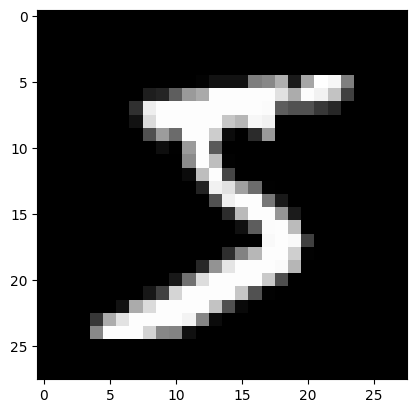

In [202]:
print(f"Dataset split: {len(x_train)} train rows")
print(f"Dataset split: {len(x_test)} test rows")

point = x_train[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [203]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [204]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [205]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [206]:
# Input image
input_img = Input(shape=(784,))

In [207]:
# encoder
encoded = Dense(256, activation='relu')(input_img)
encoded = Dropout(0.5)(encoded)
encoded = ReLU(0.5)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = ReLU(0.5)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)
encoded = ReLU(0.5)(encoded)
encoded = Dense(32, activation='relu')(encoded)

In [208]:
# decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)
encoded = ReLU(0.5)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
encoded = ReLU(0.5)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
encoded = ReLU(0.5)(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [209]:
autoencoder = Model(input_img, decoded)

In [210]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [211]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True,
                          validation_data=(x_test, x_test), callbacks=[early_stopping])

Epoch 1/100


938/938 [==============================] - 6s 6ms/step - loss: 0.0677 - val_loss: 0.0589
Epoch 2/100
938/938 [==============================] - 5s 6ms/step - loss: 0.0579 - val_loss: 0.0549
Epoch 3/100
938/938 [==============================] - 5s 6ms/step - loss: 0.0555 - val_loss: 0.0524
Epoch 4/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0539 - val_loss: 0.0510
Epoch 5/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0530 - val_loss: 0.0495
Epoch 6/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0520 - val_loss: 0.0486
Epoch 7/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0513 - val_loss: 0.0477
Epoch 8/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0509 - val_loss: 0.0477
Epoch 9/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0504 - val_loss: 0.0469
Epoch 10/100
938/938 [==============================] - 6s 6ms/step - loss: 0.0499 - val_loss: 0.0468
E

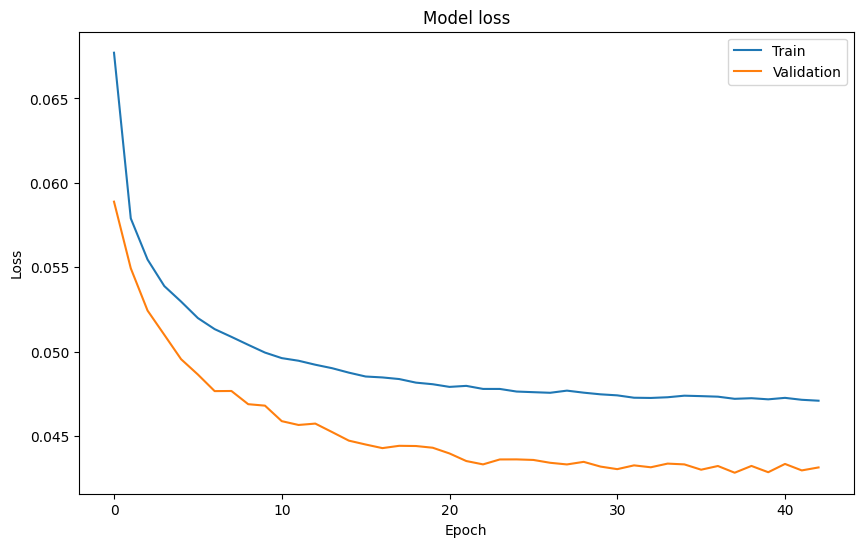

In [212]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [213]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [214]:
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=1)

In [215]:
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [216]:
# Classify anomalies based on the threshold
predictions = (reconstruction_errors > threshold).astype(int)

In [217]:
# Get corresponding labels for anomaly indexes
anomaly_labels = [y_test[i] for i in anomaly_indexes]

# Print or use anomaly_indexes and anomaly_labels as needed
print("Anomaly Indexes:", anomaly_indexes)
print("Anomaly Labels:", anomaly_labels)

Anomaly Indexes: [   8   18   72  119  124  126  149  200  222  225  242  259  287  305
  311  338  352  353  360  362  380  421  437  445  467  475  490  514
  527  549  597  611  625  631  638  642  654  655  710  715  720  744
  766  787  792  810  844  864  876  877  894  896  923  924  985  998
 1017 1023 1031 1052 1060 1073 1101 1102 1119 1128 1170 1191 1253 1263
 1272 1325 1348 1352 1377 1444 1463 1468 1526 1529 1530 1556 1569 1574
 1601 1609 1610 1618 1627 1641 1671 1692 1712 1720 1737 1748 1749 1758
 1782 1790 1801 1808 1813 1841 1843 1857 1859 1882 1895 1987 2044 2057
 2060 2115 2118 2145 2186 2215 2237 2253 2272 2291 2293 2299 2326 2333
 2351 2396 2404 2415 2436 2462 2470 2479 2515 2540 2649 2653 2664 2686
 2728 2747 2770 2773 2790 2797 2802 2830 2927 2932 2959 2990 3016 3021
 3073 3119 3120 3170 3198 3251 3260 3263 3269 3290 3295 3311 3329 3336
 3347 3348 3364 3384 3394 3401 3412 3441 3447 3488 3517 3521 3525 3534
 3540 3542 3547 3575 3681 3705 3710 3727 3768 3803 3813 3817

In [218]:
# Get all the anomalies from the test_images
anomalies = x_test[anomaly_indexes]

print(len(anomalies))

500


In [219]:
# Get anomaly labels
anomaly_indexes = np.array(anomaly_indexes, dtype=int)
label_of_anomalies = [y_test[i] for i in anomaly_indexes]

# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), label_of_anomalies))

In [220]:
anomaly_dict_serializable = {int(key): str(value) for key, value in anomaly_dict.items()}

In [221]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict_serializable, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


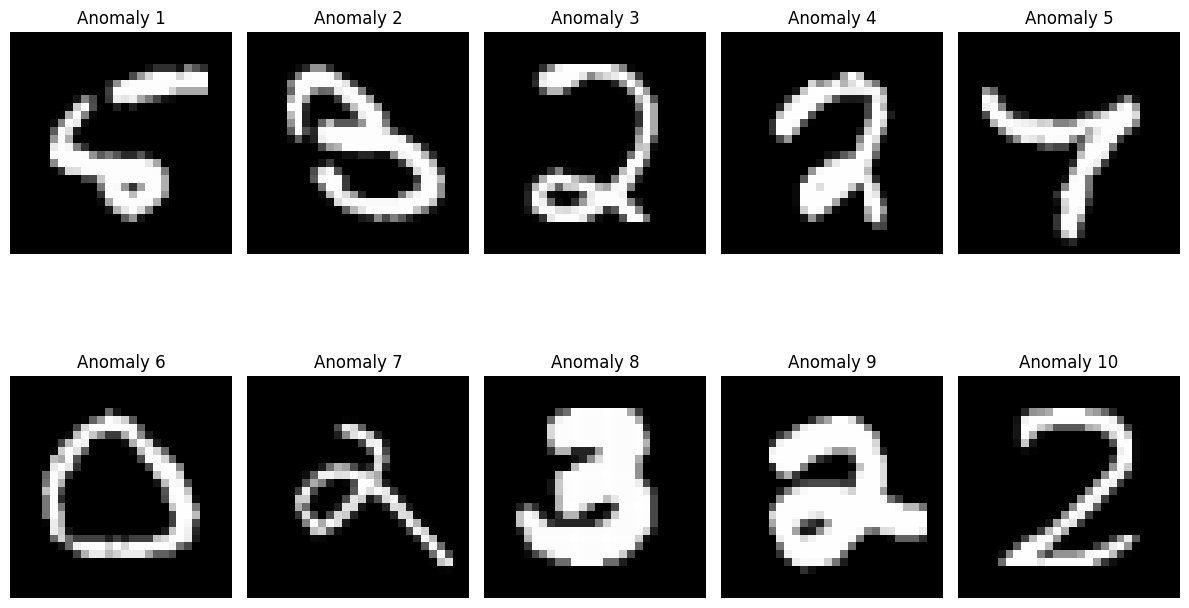

In [222]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


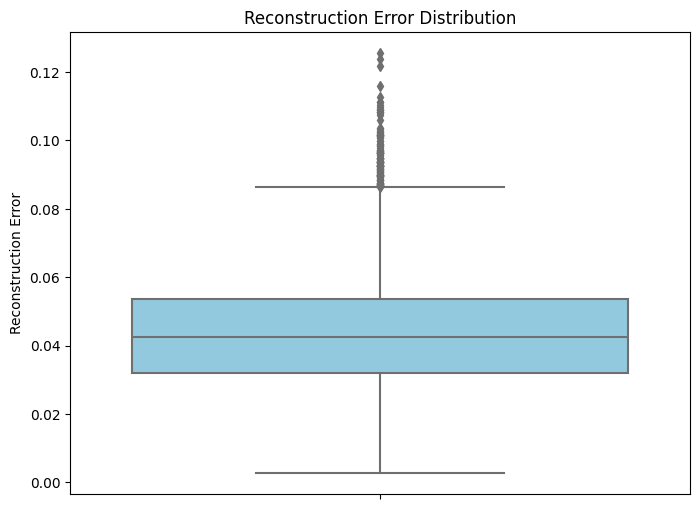

In [223]:
# Plot a boxplot of the reconstruction errors
plt.figure(figsize=(8, 6))
sns.boxplot(y=reconstruction_errors, color='skyblue')
plt.title('Reconstruction Error Distribution')
plt.ylabel('Reconstruction Error')
plt.show()

C:\Users\zippe\AppData\Local\Temp\ipykernel_22516\2073315374.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c=['red' if e > threshold else 'blue' for e in reconstruction_errors], cmap='coolwarm', marker='o', edgecolors='k')


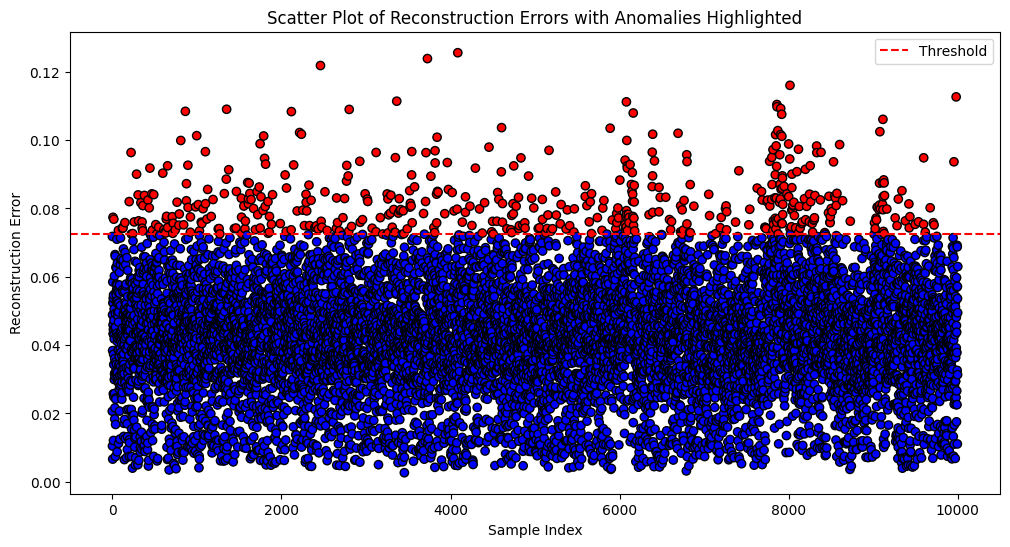

In [245]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(reconstruction_errors > threshold, 1, 0)

# Create a scatter plot of reconstruction errors with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c=['red' if e > threshold else 'blue' for e in reconstruction_errors], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors with Anomalies Highlighted')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

In [224]:
# Map the class labels to "anomaly" and "normal"
class_labels = {0: 'normal', 1: 'anomaly'}
predictions_mapped = np.vectorize(class_labels.get)(predictions)
y_test_mapped = np.vectorize(class_labels.get)(y_test)

In [225]:
# Ensure that y_test_mapped and predictions_mapped are binary (0 or 1)
y_test_mapped_binary = np.where(y_test_mapped == 'anomaly', 1, 0)
predictions_mapped_binary = np.where(predictions_mapped == 'anomaly', 1, 0)

In [226]:
# Evaluate performance metrics
accuracy = accuracy_score(y_test_mapped_binary, predictions_mapped_binary)
precision = precision_score(y_test_mapped_binary, predictions_mapped_binary)
recall = recall_score(y_test_mapped_binary, predictions_mapped_binary)
f1 = f1_score(y_test_mapped_binary, predictions_mapped_binary)

In [227]:
# Print and display the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8367
Precision: 0.002
Recall: 0.000881057268722467
F1 Score: 0.0012232415902140672


In [228]:
report = classification_report(y_test_mapped_binary, predictions_mapped_binary, target_names=['normal', 'anomaly'])

# Print or use the classification report as needed
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      normal       0.88      0.94      0.91      8865
     anomaly       0.00      0.00      0.00      1135

    accuracy                           0.84     10000
   macro avg       0.44      0.47      0.46     10000
weighted avg       0.78      0.84      0.81     10000



In [229]:
# calculate the precision and recall for different threshold levels
precision_curve, recall_curve, _ = precision_recall_curve(y_test_mapped_binary, reconstruction_errors)

# calculate the area under the precision-recall curve
pr_auc = auc(recall_curve, precision_curve)

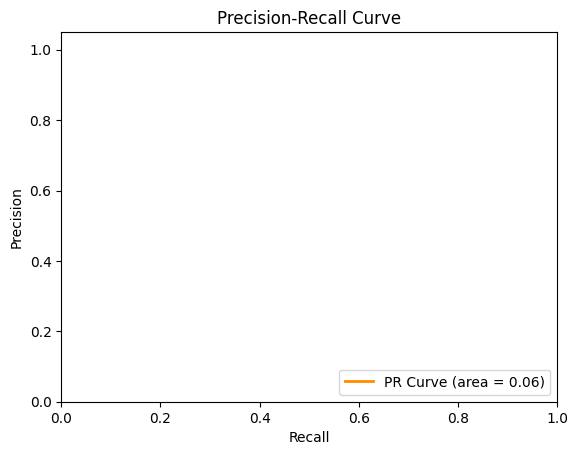

In [230]:
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [231]:
conf_matrix = confusion_matrix(y_test_mapped_binary, predictions_mapped_binary)

In [232]:
print(conf_matrix)

[[8366  499]
 [1134    1]]


In [233]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 8366
False Positives: 499
False Negatives: 1134
True Positives: 1
